In [17]:
'''
Creates plots for a grid search experiment (#28) done for torque curriculums

Requires the experiments to be available and evaluated in "torque/orig" and "torque/curr" directories.
'''

import pandas as pd
import numpy as np
import math
import glob
import csv
import re
import os

import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']

In [15]:
orig_dirs = glob.glob("../torque/orig/*/")
orig_limits = [float(re.findall("2d-(.*)power", path)[0]) for path in orig_dirs]

curr_dirs = glob.glob("../torque/curr/*/*/")
curr_limits = [float(re.findall("1.6-(.*)/.+/", path)[0]) for path in curr_dirs]

rcurr_dirs = glob.glob("../torque/revcurr/*/*/")
rcurr_limits = [float(re.findall("10b-(.*)-0.6/.+/", path)[0]) for path in rcurr_dirs]

In [5]:
def read_data(path):
    return pd.read_csv(os.path.join(path, "evaluate.csv"))

In [6]:
read_data(orig_dirs[0])

,MeanEpiRew,MeanEpiAliveRew,MeanEpiProgressRew,MeanEpiOriginalRew
0,3149.72586,999.21,2819.356291,3149.72586


In [7]:
def read_column(paths, column):
    return [read_data(path)[column].item() for path in paths]

In [23]:
read_column(orig_dirs, "MeanEpiRew")[:4]

[3149.725860301793, 970.2034253887821, 3000.581907939247, 989.5309070428592]

In [24]:
def rand_jitter(arr):
    '''
    Add a bit of jitter to the array to avoid overlapping datapoints
    https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
    '''
    stdev = .001*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def draw(column, column_name):
    radius = 30
    
    x1 = orig_limits
    y1 = read_column(orig_dirs, column)
#     x1 = rand_jitter(x1)

    x2 = curr_limits
    y2 = read_column(curr_dirs, column)
#     x2 = rand_jitter(x2)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(x1, y1, s=radius, c='r', alpha=0.7, label="Default")
    ax.scatter(x2, y2, s=radius, c='b', alpha=0.35, label="Curriculum")
    ax.set_xlabel("Torque Limit (Final)")
    ax.set_ylabel(column_name)
    plt.legend(loc='upper left')

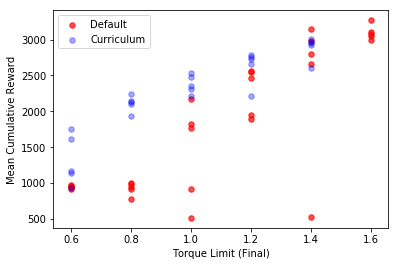

In [25]:
draw("MeanEpiRew", "Mean Cumulative Reward")

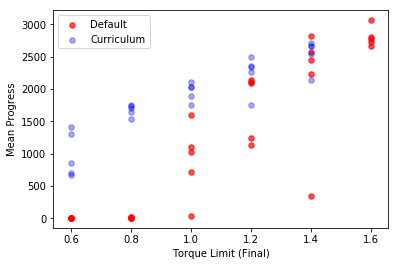

In [26]:
draw("MeanEpiProgressRew", "Mean Progress")

In [27]:
def draw_reverse(column, column_name):
    radius = 30

    x1 = rcurr_limits
    y1 = read_column(rcurr_dirs, column)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(x1, y1, s=radius, c='b', alpha=0.7, label="Curriculum ending in 0.6x")
#     ax.scatter(x2, y2, s=radius, c='b', alpha=0.35, label="Curriculum")
    ax.set_xlabel("Starting Torque Limit")
    ax.set_ylabel(column_name)
#     plt.legend(loc='upper left')

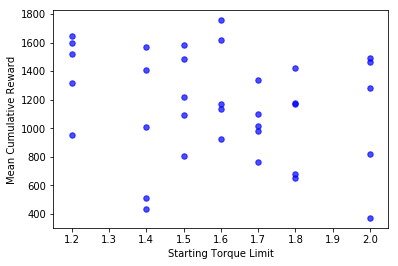

In [28]:
draw_reverse("MeanEpiRew", "Mean Cumulative Reward")

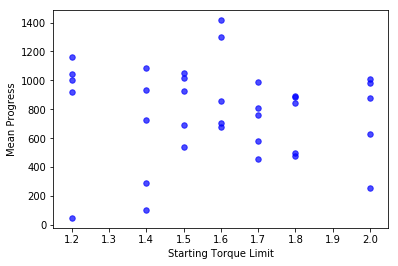

In [29]:
draw_reverse("MeanEpiProgressRew", "Mean Progress")

In [28]:
def compute_stats(xs, ys):
    grouped = {}
    for x, y in zip(xs, ys):
        x = str(x)
        if not x in grouped:
            grouped[x] = []
        grouped[x].append(y)
    keys = sorted(grouped.keys())
    xs = np.array([float(k) for k in keys])
    means = np.array([np.mean(grouped[k]) for k in keys])
    mins = np.array([np.min(grouped[k]) for k in keys])
    maxs = np.array([np.max(grouped[k]) for k in keys])
    return xs, means, means-mins, maxs - means
        
        
def draw_barplot(column, column_name, plot_curr=False):
    width = 0.05  # the width of the bars
    capsize = 3
    
    x1 = orig_limits
    y1 = read_column(orig_dirs, column)
    x, ymean, yl, yh = compute_stats(x1, y1)
    
#     x1 = rand_jitter(x1)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(x - width/2*plot_curr, ymean, width, yerr=[yl, yh], capsize=capsize, color='r', label="Default")
    if plot_curr:
        x2 = curr_limits
        y2 = read_column(curr_dirs, column)
        x, ymean, yl, yh = compute_stats(x2, y2)
        
        ax.bar(x + width/2, m, width, yerr=s, capsize=capsize, color='b', label="Curriculum")
        plt.legend(loc='upper left')

    ax.set_xlabel("Torque Limit Multiplier" + ("(Final)" if plot_curr else ""))
    ax.set_ylabel(column_name)

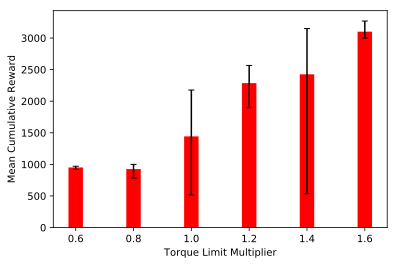

In [29]:
draw_barplot("MeanEpiRew", "Mean Cumulative Reward")

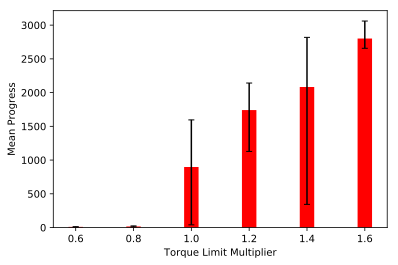

In [30]:
draw_barplot("MeanEpiProgressRew", "Mean Progress")